In this notebook, I'll demo a couple example mean-reversion strategies. I'll show common data analysis strategies in Python as well as data sources

In [ ]:
!pip install yfinance
"""library used for pulling data from yahoo finance
typically this would not be ideal as daily data is kinda far apart
and our data set lacks more interesting/useful features but for
demo purposes it's good enough"""

"library used for pulling data from yahoo finance\ntypically this would not be ideal as daily data is kinda far apart\nand our data set lacks more interesting/useful features but for\ndemo purposes it's good enough"

In [ ]:
yf.Ticker("AAPL").history(start = "2023-01-01", end = "2023-01-04")


,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2023-01-03 00:00:00-05:00,129.726523,130.343884,123.64248,124.538658,112117500,0.0,0.0


In [ ]:
import numpy as np
import pandas as pd
import datetime as dt
#standard data manipulation libraries
from pandas_datareader import data as pdr
#useful for pulling data from yfinance
from sklearn import linear_model
import statsmodels.api as sm
import yfinance as yf
#setting that'll avoid bugs

In [ ]:
yf.__version__

'0.2.28'

In [ ]:
ticker_list = 'TGT TSLA F GM  MSFT ETSY SPOT NVDA AMD META BABA PYPL NFLX SQ CRM XOM TEAM TWLO V UNH JPM SBUX ADBE BA NIO BAC PANW SNOW COP PDD CVX AVGO FIS EL MRNA QCOM WFC HD INTC OXY ENPH PFE INTU GS CAT NKE DIS TMUS TXN LLY MU CRWD MA NOW LRCX SHOP CVX AMGN JNJ CMCSA MCD DKNG SLB MRK TMO BILL CSCO ROKU HON HUM NET AMAT PG DHR T ADI CI MCHP SCHW PEP LMT WMT C WDAY VZ ACN BMY MRVL DDOG MNST EXP GM ILMN MRO KO IBM PNC ORCL ZS DOW ANET ADSK PLTR FSLR MAR AXP HAL CCL MDB FTNT UAL RTX BIDU VLO AAL UPS RCL HPQ PGR TJX LVS ADP CNC YUM GD OKTA PINS LULU DAL DPZ ATVI SNAP ZM EBAY AEP CL EA SNPS MGM MTCH WB TTWO PAYC LCID DOCU ZI BILI PLUG K COF SPLK CHWY PTON BURL LUV Z LYFT AKAM UBER'.split()
ticker_list = tuple(ticker_list)
"""
Basically just set the universe of stocks to like 160 or so pretty big/liquid companies.
It's roughly the top 160 sorted by Average Dollar Volume, denoted ADV (average price * volume)
"""

"\nBasically just set the universe of stocks to like 160 or so pretty big/liquid companies.\nIt's roughly the top 160 sorted by Average Dollar Volume, denoted ADV (average price * volume)\n"

In [ ]:
start = dt.date.today() - dt.timedelta(days = int(365.25*1.5))
mid = dt.date.today() - dt.timedelta(days = int(365.25*0.5))
end = dt.date.today()
"""
Experimental Design: Our "train" set will be the time from 1.5 years to 0.5 years ago
We'll then evaluate performance on the time from 0.5 years ago to now
"""

'\nExperimental Design: Our "train" set will be the time from 1.5 years to 0.5 years ago\nWe\'ll then evaluate performance on the time from 0.5 years ago to now\n'

In [ ]:
dataset = pdr.get_data_yahoo(list(ticker_list), start, mid)['Adj Close']
"""the pdr get_data_yahoo function pulls yahoo finance data for all the stocks in ticker_list from start to mid.
the returned columns are Open, High, Low, Adj Close, Close, and Volume. We'll just use the close prices for this basic example"""
stocks_returns = np.log(dataset/dataset.shift(1))
"""The standard way to calculate returns is log(today's price / yesterday's price)
This accounts for the inherent asymmetry that stocks can only go down 100% but can go up
unlimited amounts. In other words, it rescales [-100, infinity] to [-infinity, infinity]"""
corr_matrix = stocks_returns.corr()
"""
The .corr() function calculates the correlation between two time series
For this case, we'll take the pairwise correlations between every pair of
stocks and use the highest pairs as candidates for cointegration.
"""

[*********************100%%**********************]  157 of 157 completed


"\nThe .corr() function calculates the correlation between two time series\nFor this case, we'll take the pairwise correlations between every pair of\nstocks and use the highest pairs as candidates for cointegration. \n"

In [ ]:
processed_corr = corr_matrix.mask(np.tril(np.ones(corr_matrix.shape)).astype(bool))
#Set diagonal elements and lower triangular elements to nans
#Serves to remove duplicates and 1-correlations between an element and itself
s =  processed_corr.unstack()
#Reshapes the correlation matrix into a list of ((row, column), correlation value) pairs
so = s.sort_values(kind="quicksort", ascending = False)
#Sort the pairs by correlation value
display(so[:30])

LRCX  AMAT    0.941171
V     MA      0.920414
UAL   AAL     0.909125
MCHP  ADI     0.905137
XOM   CVX     0.903054
DAL   AAL     0.900988
SLB   HAL     0.895530
TMO   DHR     0.894918
XOM   COP     0.894787
TXN   MCHP    0.894632
RCL   CCL     0.892738
MRO   COP     0.892478
MCHP  AMAT    0.890486
TXN   ADI     0.887365
NVDA  AMD     0.886425
UAL   DAL     0.885624
CVX   COP     0.880739
JPM   BAC     0.880722
MCHP  LRCX    0.880157
XOM   MRO     0.872630
WFC   BAC     0.871736
NVDA  MRVL    0.871342
GM    F       0.869602
MCHP  AVGO    0.860706
MRO   CVX     0.860320
PEP   KO      0.860236
MRVL  MCHP    0.858850
TXN   AMAT    0.858084
MRO   HAL     0.858030
MRVL  AMAT    0.854840
dtype: float64

Our most correlated pair is (LRCX, AMAT). These logically make sense -- they're both semiconductor companies. Let's see if we can build a mean reverting strategy -- when one moves much more than the other in a direction, we'll trade them back towards each other.

In [ ]:
stocks = pdr.get_data_yahoo(['LRCX', 'AMAT'], start, mid)['Adj Close']
# Pull data for closes
stocks['LRCX_1d_return'] = np.log(stocks['LRCX']/stocks['LRCX'].shift(1))
stocks['AMAT_1d_return'] = np.log(stocks['AMAT']/stocks['AMAT'].shift(1))
# Calculate daily returns

[*********************100%%**********************]  2 of 2 completed


In [ ]:
thresh = 0.8
#hyperparameter
flag_buy = (((stocks['LRCX_1d_return']) / stocks['LRCX_1d_return'].std() - (stocks['AMAT_1d_return']) / stocks['AMAT_1d_return'].std()) > thresh).astype(int)
flag_sell = (((stocks['LRCX_1d_return']) / stocks['LRCX_1d_return'].std() - (stocks['AMAT_1d_return']) / stocks['AMAT_1d_return'].std()) < -thresh).astype(int)
# Integer flags for when to buy/sell AMAT -- buy when LRCX goes up >0.8 stdevs more than AMAT or LRCX goes down 0.8 stdevs more than AMAT
flag = flag_buy - flag_sell
profs = flag.shift() * stocks['AMAT_1d_return']
#Calculate daily profits as position * return

In [ ]:
flag

Date
2023-04-03    NaN
2023-04-04   -1.0
2023-04-05   -1.0
2023-04-06    1.0
2023-04-10    1.0
             ... 
2023-09-25   -1.0
2023-09-26   -1.0
2023-09-27    1.0
2023-09-28   -1.0
2023-09-29    1.0
Length: 125, dtype: float64

In [ ]:
profs.sum()
#Sum of total returns -- pretty good

0.2326191473934326

In [ ]:
profs[profs!=0].mean() / (profs[profs!=0].std() * abs(flag).sum()**(-1/2))
#Filter to places where daily profit isn't 0 (so a trade was made) and do a t-test

4.356577432824831

<Axes: xlabel='Date'>

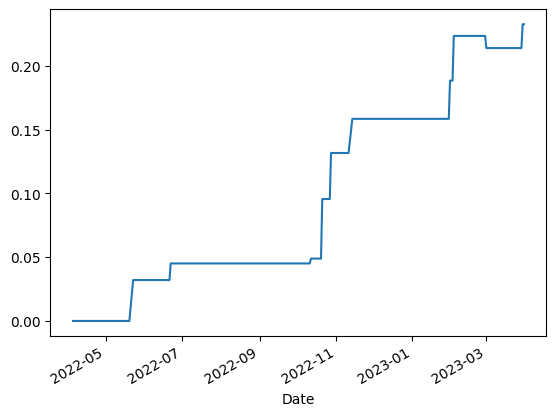

In [ ]:
profs.cumsum().plot()
#cumulative sum of returns over time == PNL

[*********************100%%**********************]  2 of 2 completed
0.049622319561454784
0.7446761868990417


<Axes: xlabel='Date'>

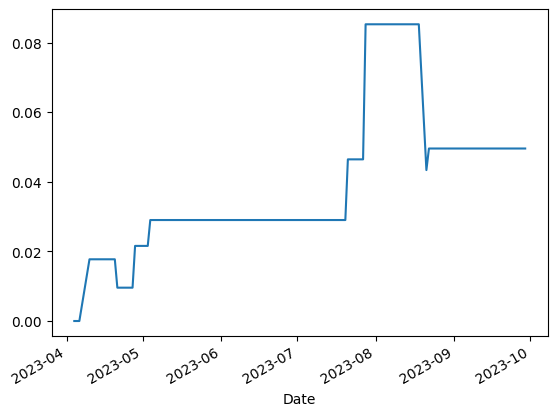

In [ ]:
stocks = pdr.get_data_yahoo(['LRCX', 'AMAT'], mid, end)['Adj Close']
# Pull data for closes
stocks['LRCX_1d_return'] = np.log(stocks['LRCX']/stocks['LRCX'].shift(1))
stocks['AMAT_1d_return'] = np.log(stocks['AMAT']/stocks['AMAT'].shift(1))
# Calculate daily returns
thresh =0.8
#hyperparameter
flag_buy = (((stocks['LRCX_1d_return']) / stocks['LRCX_1d_return'].std() - (stocks['AMAT_1d_return']) / stocks['AMAT_1d_return'].std()) > thresh).astype(int)
flag_sell = (((stocks['LRCX_1d_return']) / stocks['LRCX_1d_return'].std() - (stocks['AMAT_1d_return']) / stocks['AMAT_1d_return'].std()) < -thresh).astype(int)
# Integer flags for when to buy/sell AMAT -- buy when LRCX goes up >0.8 stdevs more than AMAT or LRCX goes down 0.8 stdevs more than AMAT
flag = flag_buy - flag_sell
profs = flag.shift() * stocks['AMAT_1d_return']
#Calculate daily profits as position * return
print(profs.sum())
#Sum of total returns -- pretty good
print(profs[profs!=0].mean() / (profs[profs!=0].std() * abs(flag).sum()**(-1/2)))
#Filter to places where daily profit isn't 0 (so a trade was made) and do a t-test
profs.cumsum().plot()
#cumulative sum of returns over time == PNL
#Still profitable, but much less impressive

In [ ]:
stocks = pdr.get_data_yahoo(['LRCX', 'AMAT'], start, mid)[['Adj Close', 'Open']]
"""
We'll try something that has a better chance of actually being a trade -- mean reversion
based on open/close prices. In the trade before, you always just get outcompeted by the
firm that trades fastest before 4. In this one, you reasonably have a chance to get your trade
"""

[*********************100%%**********************]  2 of 2 completed


In [ ]:
stocks

Adj Close                    Open            
                  AMAT        LRCX        AMAT        LRCX
Date                                                      
2022-04-04  127.575645  524.766724  127.169998  526.330017
2022-04-05  119.956985  493.499268  128.779999  528.609985
2022-04-06  117.611267  488.139404  119.010002  493.910004
2022-04-07  120.637047  493.205231  119.080002  497.339996
2022-04-08  118.232185  481.740845  121.260002  498.010010
...                ...         ...         ...         ...
2023-03-27  118.307831  492.917297  120.750000  508.260010
2023-03-28  115.849510  482.288788  118.889999  495.399994
2023-03-29  119.283188  512.782349  118.720001  494.540009
2023-03-30  121.532509  528.302490  122.000000  523.609985
2023-03-31  122.249100  527.069641  121.519997  527.640015

[250 rows x 4 columns]

10.949009996725419


<Axes: xlabel='Date'>

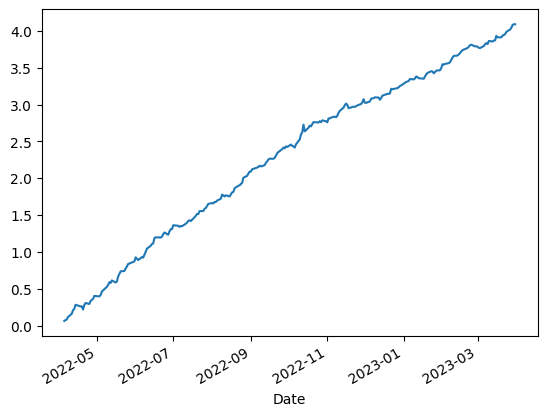

In [ ]:
flag_lrcx = -np.sign(np.log((stocks['Open']['LRCX'].shift() / stocks['Adj Close']['LRCX'])))
tot = flag_lrcx * np.log(stocks['Adj Close']['LRCX'] / stocks['Open']['LRCX'])
print(tot.mean() / (tot.std() * (len(tot)**(-1/2))))
tot.cumsum().plot()
"""
obviously this procedure has some error lol
find the bug! this is lowk a pandas q

In [ ]:
lrcx_gaps = np.log((stocks['Open']['LRCX'] / stocks['Adj Close']['LRCX'].shift()))
amat_gaps = np.log((stocks['Open']['AMAT'] / stocks['Adj Close']['AMAT'].shift()))
#Calculate "gap" -- change from yesterday's close to today's open
flag = np.sign((lrcx_gaps / lrcx_gaps.std()) - (amat_gaps / amat_gaps.std()) )
#Flag -- increase / decrease
profs = flag * np.log(stocks['Adj Close']['AMAT'] / stocks['Open']['AMAT'])

In [ ]:
(profs.mean() / (profs.std() * len(profs)**(-1/2)))

-2.582413258788475

<Axes: xlabel='Date'>

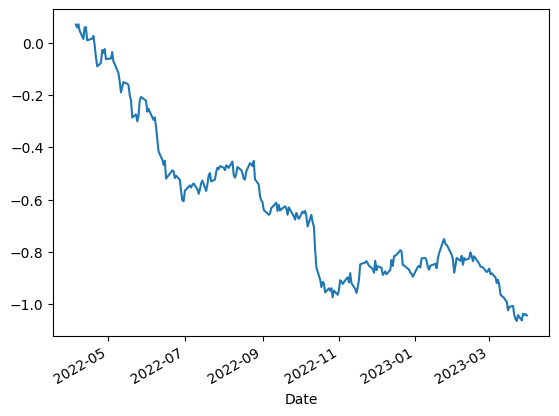

In [ ]:
profs.cumsum().plot()
#this looks really ass

In [ ]:
profs_lrcx = -flag * np.log(stocks['Adj Close']['LRCX'] / stocks['Open']['LRCX'])
print(profs_lrcx.mean()* len(profs_lrcx)**(0.5) / profs_lrcx.std())

4.890758333102531


<Axes: xlabel='Date'>

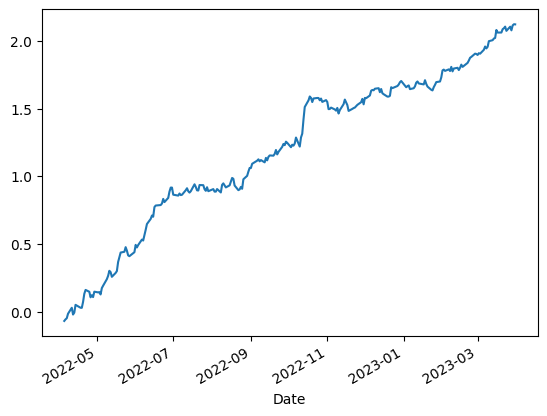

In [ ]:
profs_lrcx.cumsum().plot()
#pretty good...

In [ ]:
profs = flag * np.log(stocks['Adj Close']['AMAT'] / stocks['Open']['AMAT']) - flag * np.log(stocks['Adj Close']['LRCX'] / stocks['Open']['LRCX'])
print(profs.mean()* len(profs)**(0.5) / profs.std())

6.501356781220623


<Axes: xlabel='Date'>

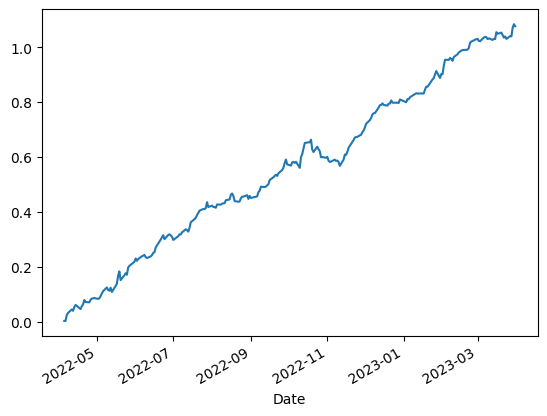

In [ ]:
profs.cumsum().plot()
#up and to the right!!! how do we get a higher t-stat by combining a "good" strategy with a "bad" strategy?

[*********************100%%**********************]  2 of 2 completed
1.1630451309899028


<Axes: xlabel='Date'>

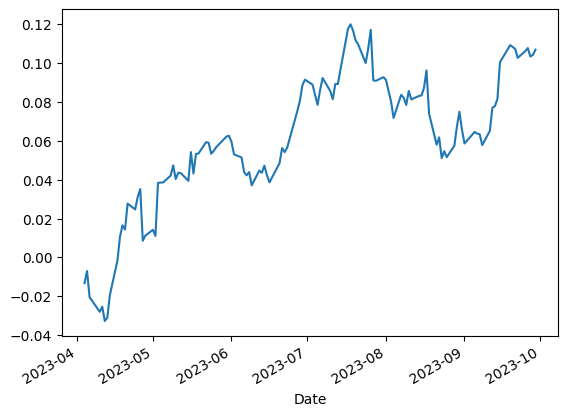

In [ ]:
stocks = pdr.get_data_yahoo(['LRCX', 'AMAT'], mid, end)[['Close', 'Open']]
lrcx_gaps = np.log((stocks['Open']['LRCX'] / stocks['Close']['LRCX'].shift()))
amat_gaps = np.log((stocks['Open']['AMAT'] / stocks['Close']['AMAT'].shift()))
flag = np.sign((lrcx_gaps / lrcx_gaps.std()) - (amat_gaps / amat_gaps.std()) )
profs = flag * np.log(stocks['Close']['AMAT'] / stocks['Open']['AMAT']) - flag * np.log(stocks['Close']['LRCX'] / stocks['Open']['LRCX'])
print(profs.mean()* len(profs)**(0.5) / profs.std())
profs.cumsum().plot()